In [1]:
import torch
import numpy as np
from dataclasses import dataclass, field
from typing import List, Tuple
import matplotlib.pyplot as plt

@dataclass
class Configs:
    
    #...general params:
    workdir : str = '../../results/moons_colored_test_1/'   
    device : str = 'cuda:0'
    multi_gpu : bool = False

    #...data params:
    source : str = 'NGaussians'
    target : str = 'TwoMoons'
    num_points : int = 70000
    dim_continuous : int = 2
    dim_discrete : int = 1
    dim_context : int = 0
    num_gaussians : int = 8
    vocab_size : int = 8

    #...model params:
    model : str = 'mlp'
    num_layers : int = 4
    dim_hidden : int = 128 
    dim_continuous_emb : int = 16
    dim_discrete_emb : int = 16
    dim_time_emb : int = 16
    continuous_embedding : str = 'linear'    
    discrete_embedding : str = 'linear'
    time_embedding : str = 'sinusoidal'    
    dropout : float = 0.0
    activation : str = 'SELU'
    use_batch_norm : bool = False
    
    #...training params:
    batch_size : int = 256
    data_split_frac : List[float] = field(default_factory = lambda : [0.8, 0.2, 0.0])  # train / val / test 
    epochs: int = 500
    early_stopping : int = None
    min_epochs : int = None 
    print_epochs : int = None   
    num_workers : int = 0
    pin_memory: bool = False

    #...cfm params:
    dynamics : str = 'CMB'
    sigma: float = 1e-3
    gamma: float = 1e-1
    lam : float = 3.0

    #...optimization & scheduler params:
    optimizer: str = 'Adam'
    lr : float = 2e-4
    weight_decay : float = 0.0
    optimizer_betas : List[float] = field(default_factory = lambda : [0.9, 0.999])
    optimizer_eps : float = 1e-8
    optimizer_amsgrad : bool = False
    gradient_clip : float = None
    scheduler: str = None
    scheduler_t_max: int = None
    scheduler_eta_min: float = None
    scheduler_gamma: float = None
    scheduler_step_size: int = None

    #...generation pipeline params:
    sampler : str = 'EulerLeapingSolver'
    num_timesteps : int = 1000
    time_eps : float = 0

    def __post_init__(self):

        self.data = self.source + '_to_' + self.target

        if self.dim_discrete: 
            assert self.dim_discrete == 1
            self.dim_context = 0
            self.dim_context_emb = 0 
            self.num_colors = self.vocab_size
        else:
            self.dim_discrete_emb = 0
            self.num_colors = 1

        if self.dim_context:  
            assert self.dim_context == 1
            self.dim_discrete = 0
            self.dim_discretet_emb = 0 
            self.num_colors = self.vocab_size
        else:
            self.dim_context_emb = 0
            self.num_colors = 1

        if self.multi_gpu: self.device = 'cuda:0'



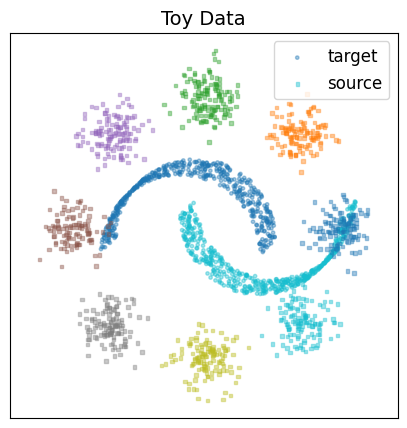

2024-09-16 22:44:31.315974: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-16 22:44:31.359525: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-16 22:44:31.360299: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-16 22:44:32.123751: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
number of training parameters: 41034
start training...


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.8/0.2/0.0
INFO: train size: 56000, validation size: 14000, testing sizes: 0


epochs:   0%|          | 0/500 [00:00<?, ?it/s]

In [2]:
from cmb.data.toys import CouplingData

config = Configs()
toys = CouplingData(config=config)

_, ax = plt.subplots(1, 1, figsize=(5,5)) 
toys.target.display(num_points=1000, s=6, cmap='tab10', alpha=0.4, ax=ax, label='target')
toys.source.display(num_points=1000, s=6, marker='s', cmap='tab10', alpha=0.4, ax=ax, label='source')
plt.legend(fontsize=12)
plt.title('Toy Data', fontsize=14)
plt.show()

from cmb.dynamics.cmb import ConditionalMarkovBridge, OTCMB, SBCMB
from cmb.models.architectures.deep_nets import MixedDataMLP
from cmb.models.trainers import CMBTrainer

dynamics = OTCMB(config)
mixmlp = MixedDataMLP(config)
model = CMBTrainer(dynamics, mixmlp, toys)
model.train()

In [ ]:
from cmb.models.pipelines import Pipeline

pipeline = Pipeline(trained_model=model, config=config)
input = CouplingData(config=config)
pipeline.generate_samples(source_continuous=input.source.continuous, source_discrete=input.source.discrete.unsqueeze(1))

def plot_trajectories(paths, jumps, title='CMB', N=2000, cmap='tab10', show_paths=False):
    """Plot trajectories of some selected samples."""
    plt.figure(figsize=(5,5))
    vmin, vmax = jumps.min(), jumps.max()
    if show_paths:
        for i in range(N):
            plt.plot(paths[:, i, 0], paths[:, i, 1], alpha=0.3, lw=0.2, color='k')  # Plot lines for each trajectory
    plt.scatter(paths[0, :N, 0], paths[0, :N, 1], s=4, c=jumps[0, :N], cmap=cmap, label='t=0', vmin=vmin, vmax=vmax)
    plt.scatter(paths[-1, :N, 0], paths[-1, :N, 1], s=4, c=jumps[-1, :N], cmap=cmap, label='t=1', vmin=vmin, vmax=vmax)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.axis('equal')
    plt.show()

In [ ]:
plot_trajectories(pipeline.paths, pipeline.jumps,title='OT-CMB ($\sigma=10^{-3}$, $\gamma=0.1$)', N=1000, show_paths=True)